In [1]:
import os, tempfile
import logging
import matplotlib.pyplot as plt

In [2]:
from ionchannelABC import theoretical_population_size
from ionchannelABC import IonChannelDistance, EfficientMultivariateNormalTransition, IonChannelAcceptor
from ionchannelABC import plot_sim_results, plot_parameters_kde
from ionchannelABC.experiment import setup

INFO:myokit:Loading Myokit version 1.28.3


In [3]:
from pyabc import Distribution, RV, History, ABCSMC
from pyabc.epsilon import MedianEpsilon
from pyabc.sampler import MulticoreEvalParallelSampler, SingleCoreSampler
from pyabc.populationstrategy import ConstantPopulationSize

In [4]:
from experiments.ina_sakakibara import (sakakibara_act,
                                        sakakibara_inact,
                                        sakakibara_inact_kin,
                                        sakakibara_rec)
from experiments.ina_schneider import (schneider_taum,
                                       schneider_taus,
                                       schneider_inact)

In [5]:
modelfile = 'models/nygren_ina.mmt'

In [6]:
observations, model, summary_statistics = setup(modelfile,
                                                sakakibara_act,
                                                schneider_taum,
                                                schneider_inact,
                                                sakakibara_inact_kin,
                                                schneider_taus,
                                                sakakibara_rec)

In [7]:
assert len(observations)==len(summary_statistics(model({})))

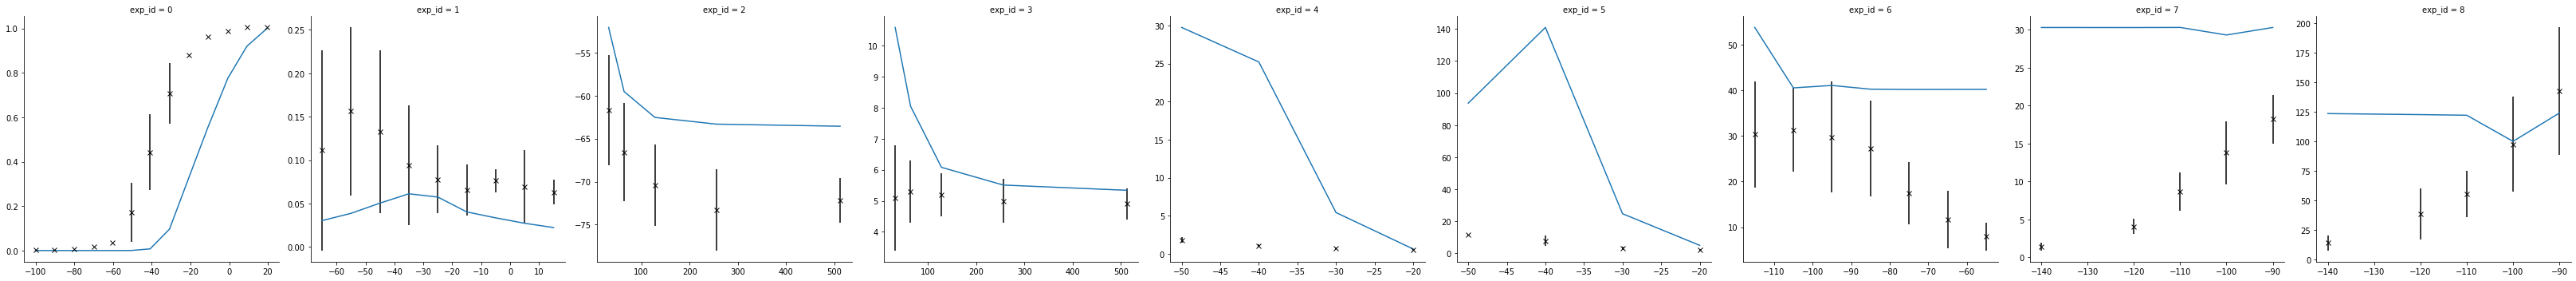

In [8]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     schneider_inact,
                     sakakibara_inact_kin,
                     schneider_taus,
                     sakakibara_rec)

In [9]:
limits = {'ina.s1': (0, 1),
          'ina.r1': (0, 200),
          'ina.r2': (0, 50),
          'ina.q1': (0, 200),
          'ina.q2': (0, 50),
          'log_ina.r3': (-6, -3),
          'ina.r4': (0, 200),
          'ina.r5': (0, 50),
          'log_ina.r6': (-6, -3),
          'log_ina.q3': (-3., 0.),
          'ina.q4': (0, 200),
          'ina.q5': (0, 50),
          'log_ina.q6': (-5, -2),
          'log_ina.q7': (-3., 0.),
          'log_ina.q8': (-4, -1)}
prior = Distribution(**{key: RV("uniform", a, b - a)
                        for key, (a,b) in limits.items()})

### Run ABC calibration

In [10]:
db_path = ("sqlite:///" +
            os.path.join(tempfile.gettempdir(), "nygren_ina_full.db"))

In [11]:
logging.basicConfig()
abc_logger = logging.getLogger('ABC')
abc_logger.setLevel(logging.DEBUG)
eps_logger = logging.getLogger('Epsilon')
eps_logger.setLevel(logging.DEBUG)

In [12]:
pop_size = theoretical_population_size(2, len(limits))
print("Theoretical minimum population size is {} particles".format(pop_size))

Theoretical minimum population size is 32768 particles


In [13]:
abc = ABCSMC(models=model,
             parameter_priors=prior,
             distance_function=IonChannelDistance(
                 exp_id=list(observations.exp_id),
                 variance=list(observations.variance),
                 delta=0.05),
             population_size=ConstantPopulationSize(2000),
             summary_statistics=summary_statistics,
             transitions=EfficientMultivariateNormalTransition(),
             eps=MedianEpsilon(initial_epsilon=100),
             sampler=MulticoreEvalParallelSampler(n_procs=8),
             acceptor=IonChannelAcceptor())

DEBUG:ABC:ion channel weights: {'0': 0.9394391387034305, '1': 0.9394391387034305, '2': 0.9394391387034305, '3': 0.9394391387034305, '4': 0.9394391387034305, '5': 0.35626430758408134, '6': 0.2771722345077288, '7': 0.3445054065594221, '8': 0.9394391387034305, '9': 0.9394391387034305, '10': 0.9394391387034305, '11': 0.9394391387034305, '12': 0.9394391387034305, '13': 0.09192085805156293, '14': 0.10976779606418227, '15': 0.11342592066171239, '16': 0.15389657343530141, '17': 0.2710170049214851, '18': 0.35819966766931594, '19': 0.7955412959142383, '20': 0.25102799110307517, '21': 0.7562515600019684, '22': 1.3987368051101545, '23': 1.5705115004745596, '24': 1.9046628835542532, '25': 1.9046628835542532, '26': 2.4425417606289193, '27': 0.3807491568039198, '28': 0.6472735665666637, '29': 0.9246765236666623, '30': 0.9246765236666623, '31': 1.2945471331333274, '32': 0.797601850771462, '33': 1.5702786437063152, '34': 2.1847355042870484, '35': 3.0531772007861493, '36': 3.0531772007861493, '37': 0.56

In [14]:
obs = observations.to_dict()['y']
obs = {str(k): v for k, v in obs.items()}

In [15]:
abc_id = abc.new(db_path, obs)

INFO:History:Start <ABCSMC(id=2, start_time=2019-09-27 12:32:17.714217, end_time=None)>


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

INFO:ABC:t:0 eps:100
DEBUG:ABC:now submitting population 0


In [ ]:
history = abc.run(minimum_epsilon=0., max_nr_populations=100, min_acceptance_rate=0.01)

### Database results analysis

In [18]:
history = History(db_path)

In [19]:
history.all_runs()

[<ABCSMC(id=1, start_time=2019-09-24 14:06:35.023569, end_time=2019-09-25 20:51:44.259095)>,
 <ABCSMC(id=2, start_time=2019-09-27 12:32:17.714217, end_time=2019-10-01 08:26:21.342653)>]

In [20]:
df, w = history.get_distribution(m=0)

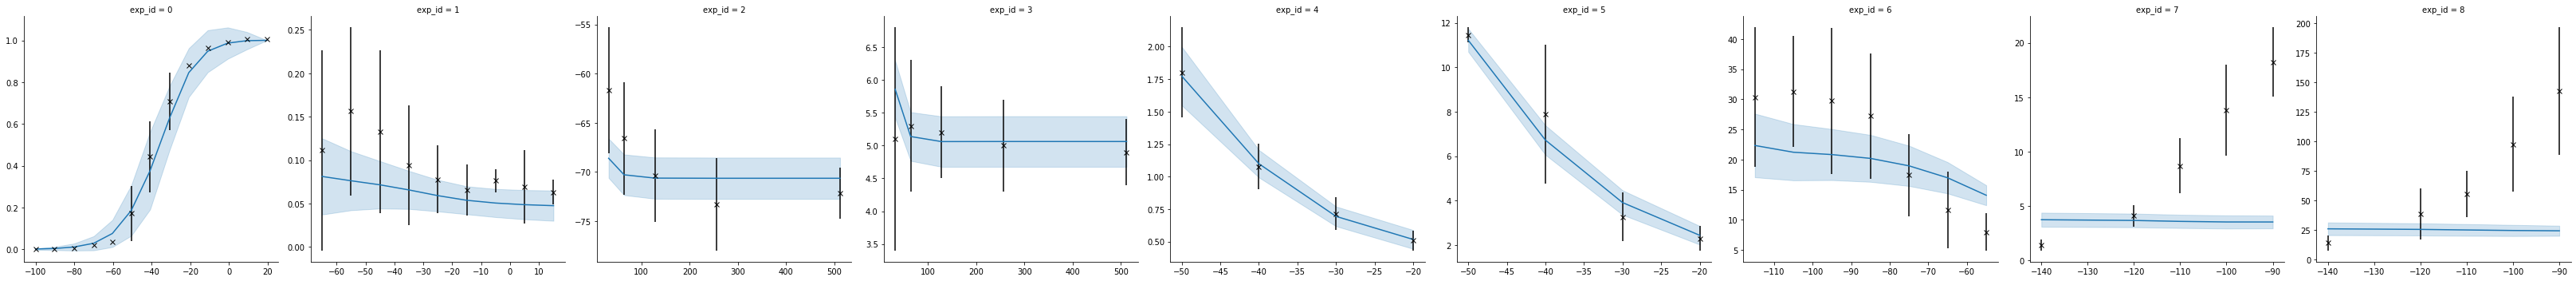

In [21]:
g = plot_sim_results(modelfile,
                     sakakibara_act,
                     schneider_taum,
                     schneider_inact,
                     sakakibara_inact_kin,
                     schneider_taus,
                     sakakibara_rec,
                     df=df, w=w)

In [22]:
from ionchannelABC.visualization import plot_kde_matrix_custom
import myokit
import numpy as np

In [23]:
m,_,_ = myokit.load(modelfile)

In [24]:
originals = {}
for name in limits.keys():
    if name.startswith("log"):
        name_ = name[4:]
    else:
        name_ = name
    val = m.value(name_)
    if name.startswith("log"):
        val_ = np.log10(val)
    else:
        val_ = val
    originals[name] = val_

In [25]:
limits.keys()

dict_keys(['ina.s1', 'ina.r1', 'ina.r2', 'ina.q1', 'ina.q2', 'log_ina.r3', 'ina.r4', 'ina.r5', 'log_ina.r6', 'log_ina.q3', 'ina.q4', 'ina.q5', 'log_ina.q6', 'log_ina.q7', 'log_ina.q8'])

In [26]:
act_params = ['ina.s1','ina.r1','ina.r2','log_ina.r3','ina.r4','ina.r5','log_ina.r6']

In [27]:
df_act = df[act_params]

In [28]:
limits_act = dict([(key, limits[key]) for key in act_params])

In [29]:
originals_act = dict([(key, originals[key]) for key in act_params])

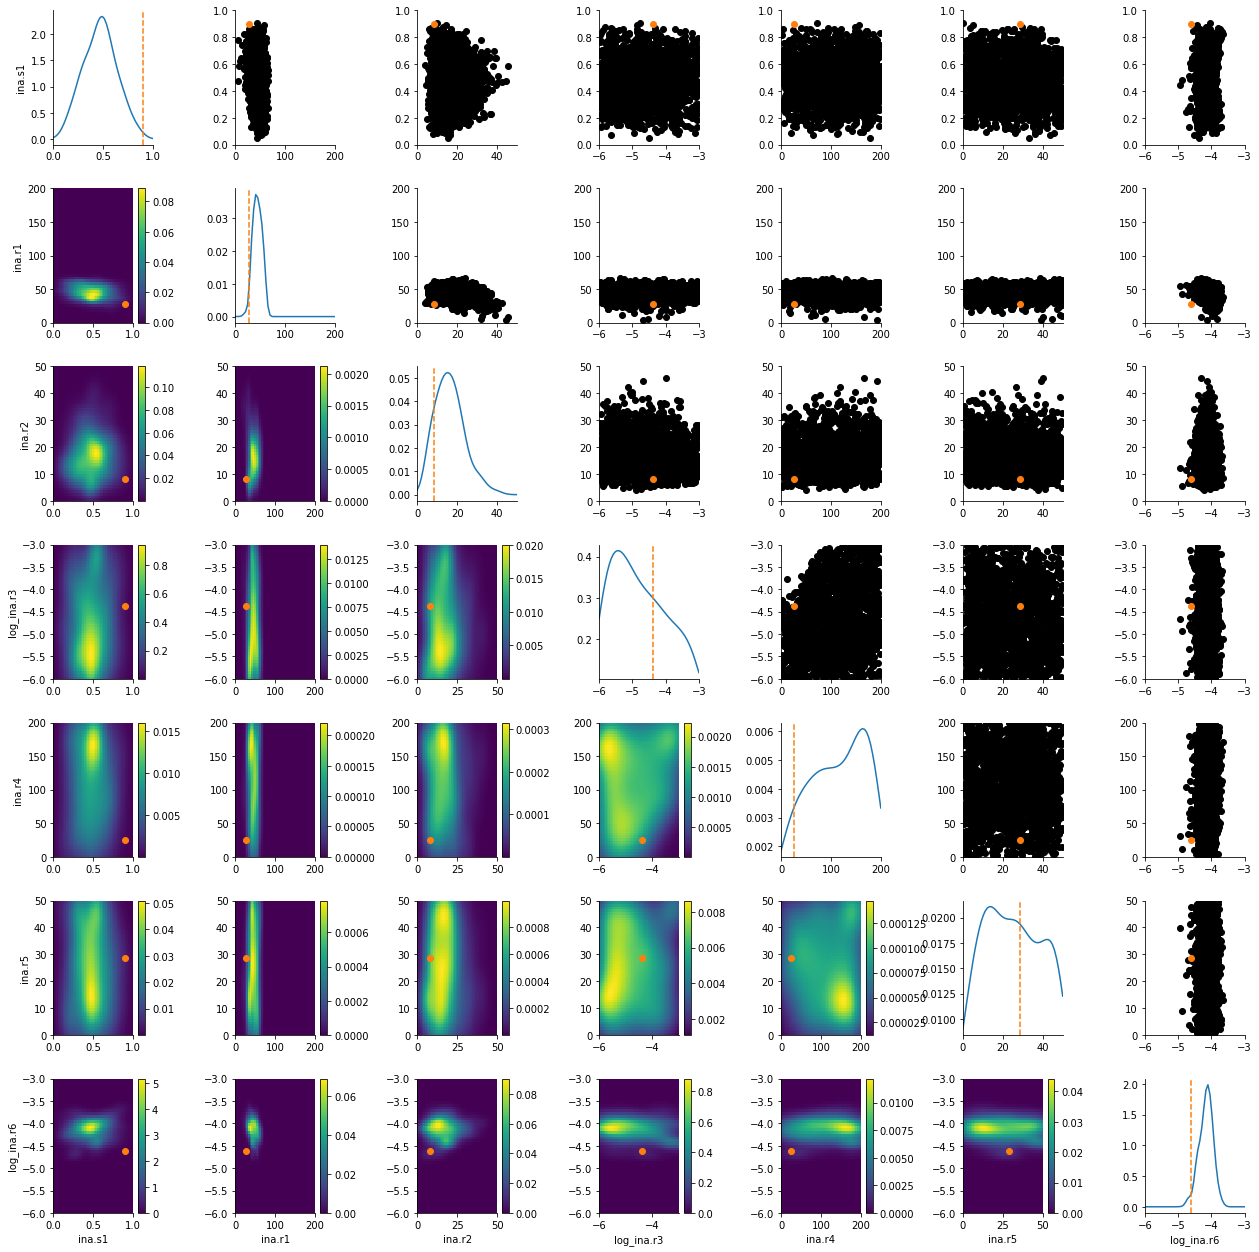

In [30]:
g = plot_kde_matrix_custom(df_act, w, limits=limits_act, refval=originals_act)

In [31]:
inact_params = ['ina.s1','ina.q1','ina.q2','log_ina.q3','ina.q4','ina.q5','log_ina.q6','log_ina.q7','log_ina.q8']

In [32]:
df_inact = df[inact_params]

In [33]:
limits_inact = dict([(key, limits[key]) for key in inact_params])

In [34]:
originals_inact = dict([(key, originals[key]) for key in inact_params])

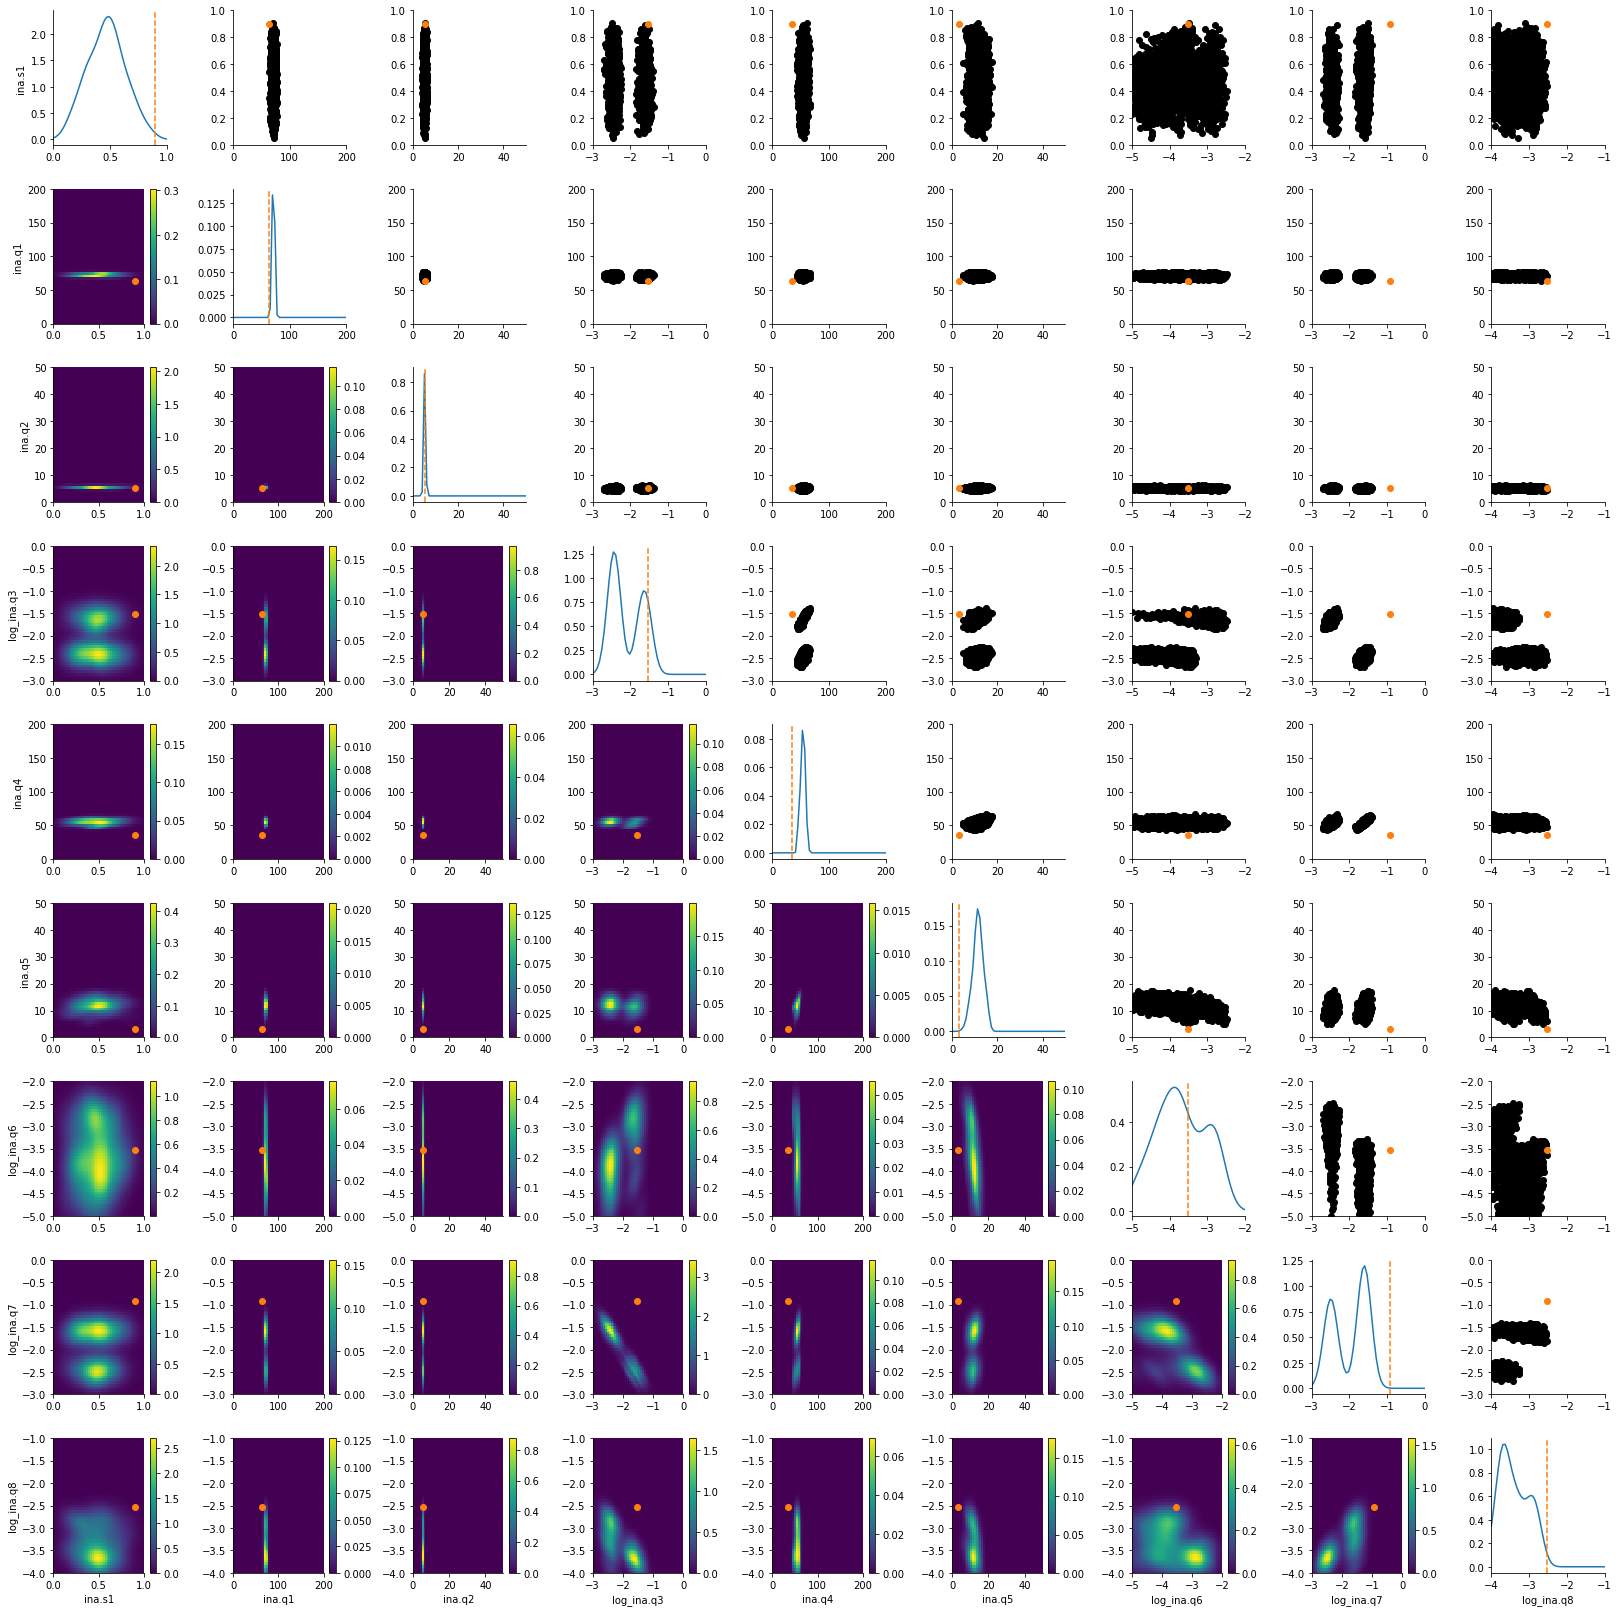

In [35]:
g = plot_kde_matrix_custom(df_inact, w, limits=limits_inact, refval=originals_inact)